# NBA Draft prediction

**Máté Czimer**

**NBA-ML-Project**

## 1. Initial steps

import libs:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ML_Framework as fw
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

import data instance:

In [2]:
data = fw.NBA_data()
y_true = np.array(data.y)

set random state:

In [3]:
random_state = 777

## 2. Baseline predictions

In order to measure the performance of more advanced machine learning models, it is a good starting point to apply intuitive solutions on the data itself. These algorithms can provide a baseline for the evaluation of further models, which helps to understand the accuracy and reliability of the different algorithms that will be used for prediction.

### 2.1. Efficiency (EFF) statistics, efficiency-based prediction

define efficiency statistical model:

In [4]:
def eff_model(data=data):

    # store years for iteration
    years = data.df['year'].unique()

    # initiate list object for predictions
    eff_y_pred = []

    # iterate over the data year-by-year
    for i in years:

        # select subset of data for each year
        target_df = data.df[data.df.year == i]

        # count drafted players for each year
        target_drafted_cnt = target_df[target_df.iloc[:,-1]==1].count()[0]

        # select efficiency statistics column
        target_eff = np.array(target_df.iloc[:,-2])

        # select top candidates for the draft based on efficiency
        target_top_eff = np.argsort(target_eff)[::-1][:target_drafted_cnt]

        # store predicted drafted players
        eff_y_pred.extend(target_top_eff)

        # sort indices for output
        eff_y_pred.sort()

        # create output vector
        output = np.array([1 if i in eff_y_pred else 0 for i in range(len(data.df))])

    return(output)

predict drafted flag based on efficiency:

In [5]:
y_pred_eff = eff_model(data=data)

evaluate the model:

In [6]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc = fw.eval_scores(y_true=data.y,y_pred=y_pred_eff)
eval_scores_eff = [precision,accuracy,recall,f1_score,bal_acc]
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Precision of draft predictions: {0:.4%}'.format(precision),
      'Accuracy: {0:.4%}'.format(accuracy),
      'Recall: {0:.4%}'.format(recall),
      'F1-score: {0:.4%}'.format(f1_score),
      'Balanced accuracy: {0:.4%}'.format(bal_acc),
      sep='\n')

Confusion matrix: 
[[59893   566]
 [  599     3]]

Precision of draft predictions: 0.4983%
Accuracy: 0.5124%
Recall: 98.0921%
F1-score: 49.7746%
Balanced accuracy: 49.7811%


### 2.2. Random model using empirical Bernoulli distribution

import random model from framework:

In [7]:
random_model = fw.random_model(X=data.X,y=data.y)

predict drafted flag using the random model:

In [8]:
y_pred_random = random_model.y_pred

evaluate the model:

In [9]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc = fw.eval_scores(y_true=data.y,y_pred=y_pred_random)
eval_scores_random = [precision,accuracy,recall,f1_score,bal_acc]
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Precision of draft predictions: {0:.4%}'.format(precision),
      'Accuracy: {0:.4%}'.format(accuracy),
      'Recall: {0:.4%}'.format(recall),
      'F1-score: {0:.4%}'.format(f1_score),
      'Balanced accuracy: {0:.4%}'.format(bal_acc),
      sep='\n')

Confusion matrix: 
[[59870   589]
 [  597     5]]

Precision of draft predictions: 0.8306%
Accuracy: 0.8361%
Recall: 98.0577%
F1-score: 49.9277%
Balanced accuracy: 49.9282%


## 3. Machine Learning algorithms against the baseline models

In this section, I construct different ML classification models to beat the baseline predictions. I also apply different hyperparameter tuning techniques on all predictors to gain information about their behaviors on the data set. 

As it turned out during the exploratory data analysis, the data is clearly inbalanced. To evaluate the results I use stratified cross-validation.

### 3.1. Logistic regression

import logistic regression model from framework:

In [10]:
logreg = fw.logistic_regression()

scale predictor variables using MinMaxScaler:

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data.X)

#### 3.1.1. Stratified 5-fold cross validation without hyperparameter tuning

In [12]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,logreg_5scv = fw.skf_cross_val(
    X=X_scaled, 
    y=data.y, 
    model=logreg, 
    number_of_splits=5,
    random_state=random_state
    )

eval_scores_logreg_5scv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [13]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[12080,    12],
       [   90,    31]], dtype=int64), array([[12078,    14],
       [   94,    26]], dtype=int64), array([[12077,    15],
       [   77,    43]], dtype=int64), array([[12082,    10],
       [   93,    27]], dtype=int64), array([[12068,    23],
       [   81,    40]], dtype=int64)]

Max precision of draft predictions: 35.8333%
Max accuracy: 48.3146%
Max recall: 99.2466%
Max F1-score: 73.9676%
Max balanced accuracy: 67.8546%


plot the evaluation scores:

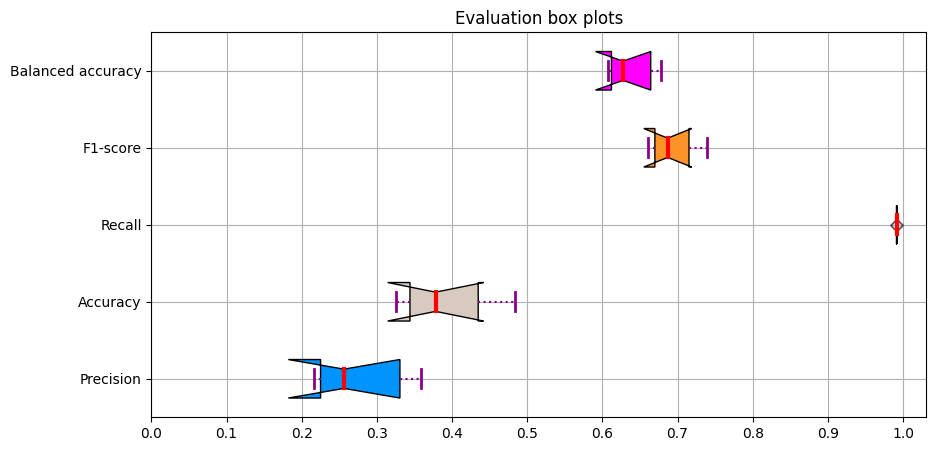

In [14]:
fw.boxplot_eval_scores(eval_data=eval_scores_logreg_5scv)

plot confusion matrices:

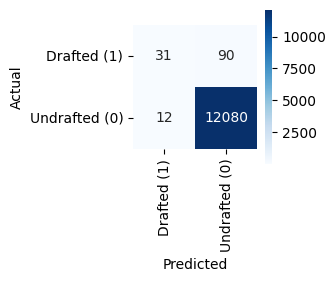

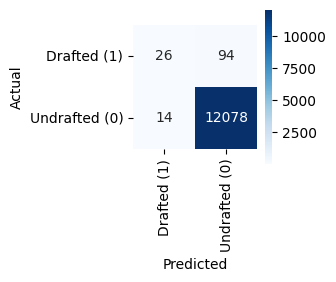

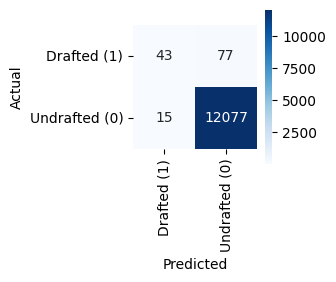

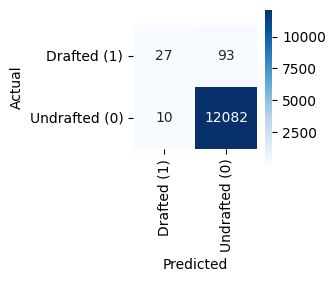

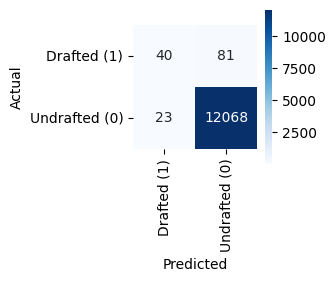

In [15]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

#### 3.1.2. Hyperparameter tuning - GridSearch CV

Train test split for grid search based on the year variable:

In [16]:
from sklearn.preprocessing import StandardScaler

train_data = data.df[data.df['year'] < 2020].drop(labels='year',axis=1)
test_data = data.df[data.df['year'] >= 2020].drop(labels='year',axis=1)

X_train, y_train, X_test, y_test = train_data.iloc[:,:-1], train_data.iloc[:,-1], test_data.iloc[:,:-1], test_data.iloc[:,-1]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

define parameter grid for the logistic regression model:

In [17]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
dual = [True,False]
tol = [1e-4,1e-3,1e-2]
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
fit_intercept = [True,False]
class_weight = ['balanced']

param_grid_logreg = dict(
    C=C
    ,penalty = penalty
    ,dual = dual
    ,class_weight = class_weight
    ,tol = tol
    ,solver = solver
    ,fit_intercept = fit_intercept
    ,random_state = [random_state]
)

print(param_grid_logreg)

{'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]), 'penalty': ['l1', 'l2'], 'dual': [True, False], 'class_weight': ['balanced'], 'tol': [0.0001, 0.001, 

run gridsearch stratified two-fold cross validation to find best parameters:

In [18]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,logreg_gs2cv = fw.gridsearch_cv(
    X_train=X_train,y_train=y_train,
    X_test=X_test,y_test=y_test,
    number_of_splits=2,param_grid=param_grid_logreg,
    model=logreg.model,
    random_state=random_state
    )

Fitting 2 folds for each of 7200 candidates, totalling 14400 fits


store evaluation scores for visualization:

In [19]:
eval_scores_logreg_gs2cv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [20]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[9114,  491],
       [   8,   90]], dtype=int64)]

Max precision of draft predictions: 91.8367%
Max accuracy: 94.8573%
Max recall: 94.8573%
Max F1-score: 61.9225%
Max balanced accuracy: 93.3624%


plot the evaluation of the model:

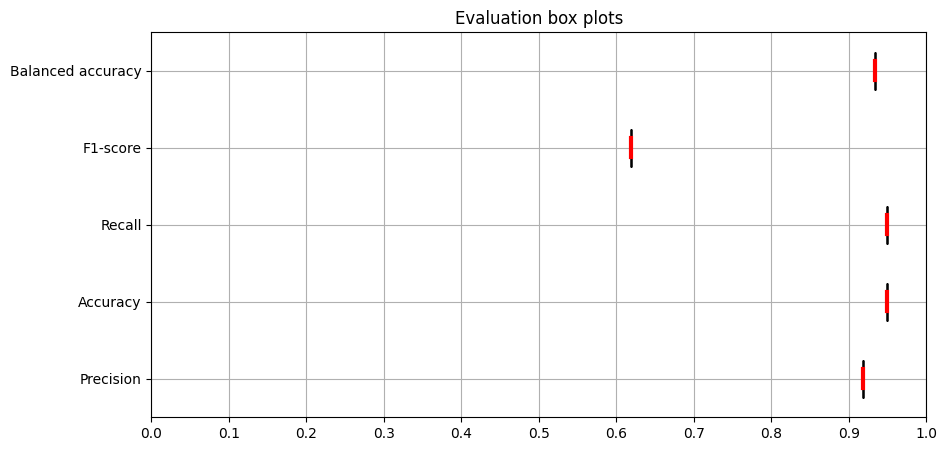

In [21]:
fw.boxplot_eval_scores(eval_data=eval_scores_logreg_gs2cv)

plot confusion matrices:

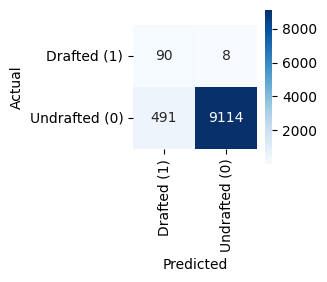

In [22]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

best hyperparameters found by the grid search cross validation for logistic regression:

In [23]:
logreg_gs2cv.best_params_

{'C': 0.013257113655901081,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'penalty': 'l1',
 'random_state': 777,
 'solver': 'liblinear',
 'tol': 0.0001}

### 3.2. Decision tree

import decision tree model from framework:

In [24]:
dtree = fw.decision_tree()

#### 3.2.1. Stratified 5-fold cross validation without hyperparameter tuning

In [26]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,dtree_5scv = fw.skf_cross_val(
    X=X_scaled, 
    y=data.y, 
    model=dtree, 
    number_of_splits=5,
    random_state=random_state
    )

eval_scores_dtree_5scv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [27]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[12024,    68],
       [   80,    41]], dtype=int64), array([[11994,    98],
       [   83,    37]], dtype=int64), array([[12000,    92],
       [   80,    40]], dtype=int64), array([[12009,    83],
       [   73,    47]], dtype=int64), array([[12002,    89],
       [   71,    50]], dtype=int64)]

Max precision of draft predictions: 41.3223%
Max accuracy: 38.4615%
Max recall: 98.7882%
Max F1-score: 68.8997%
Max balanced accuracy: 70.2931%


plot the evaluation scores:

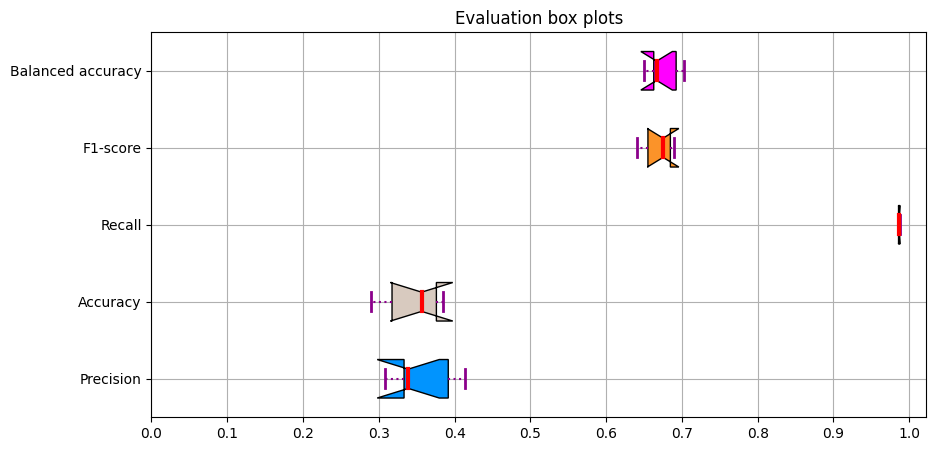

In [28]:
fw.boxplot_eval_scores(eval_data=eval_scores_dtree_5scv)

plot confusion matrices:

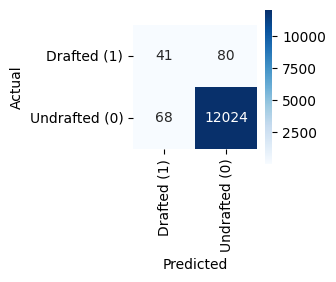

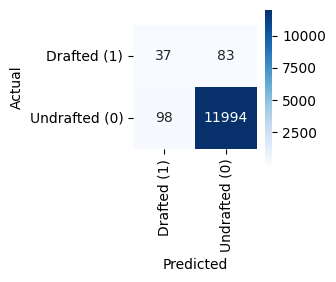

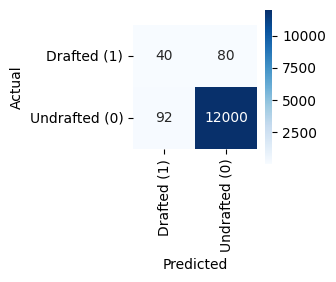

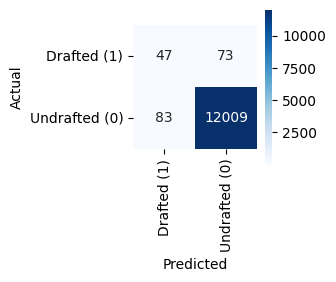

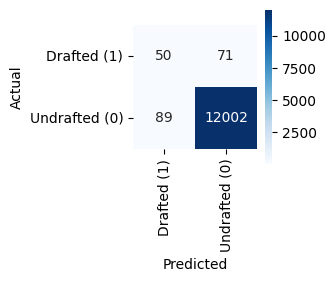

In [29]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

#### 3.2.2. Hyperparameter tuning - GridSearch CV

define parameter grid for the decision tree model:

In [30]:
param_grid_dtree = dict(    
    criterion = ['gini', 'entropy', 'log_loss']
    ,splitter = ['best', 'random']
    ,max_depth = [None, 5, 10]
    ,min_samples_split = [2, 5, 10]
    ,min_samples_leaf = [1, 2, 4]
    ,max_features = ['auto', 'sqrt']
    ,max_leaf_nodes = [None, 10, 20]
    ,min_impurity_decrease = [0.0, 0.1, 0.2]
    ,class_weight=['balanced']
    ,random_state = [random_state]
)

print(param_grid_dtree)

{'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'], 'max_leaf_nodes': [None, 10, 20], 'min_impurity_decrease': [0.0, 0.1, 0.2], 'class_weight': ['balanced'], 'random_state': [777]}


run gridsearch stratified two-fold cross validation to find best parameters:

In [54]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,dtree_gs2cv = fw.gridsearch_cv(
    X_train=X_train,y_train=y_train,
    X_test=X_test,y_test=y_test,
    number_of_splits=2,param_grid=param_grid_dtree,
    model=dtree.model,random_state=random_state
    )

Fitting 2 folds for each of 2916 candidates, totalling 5832 fits


store evaluation scores for visualization:

In [55]:
eval_scores_dtree_gs2cv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [56]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[9037,  568],
       [  17,   81]], dtype=int64)]

Max precision of draft predictions: 82.6531%
Max accuracy: 93.9709%
Max recall: 93.9709%
Max F1-score: 59.2758%
Max balanced accuracy: 88.3697%


plot the evaluation of the model:

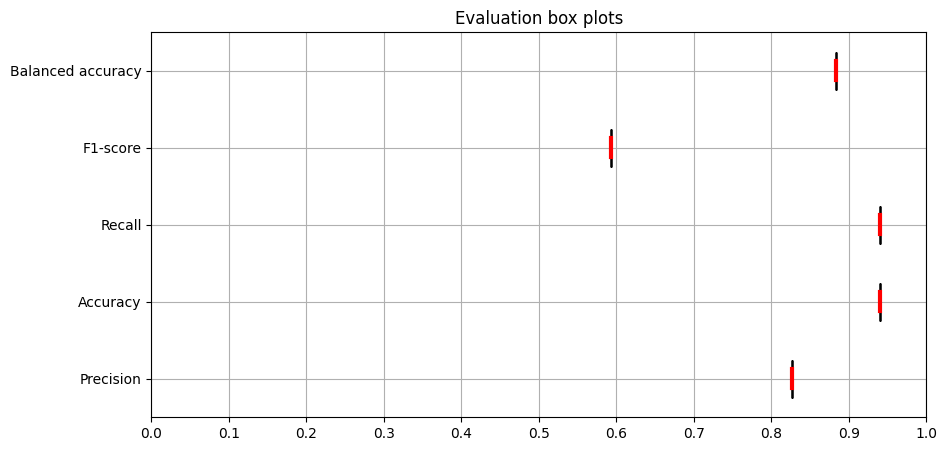

In [57]:
fw.boxplot_eval_scores(eval_data=eval_scores_dtree_gs2cv)

plot confusion matrices:

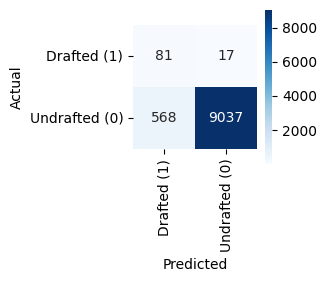

In [58]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

visualize decision tree:

In [47]:
dtree_gs2cv.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 777,
 'splitter': 'best'}

[Text(0.375, 0.9166666666666666, 'adjoe <= 0.653\ngini = 0.5\nsamples = 51358\nvalue = [25679.0, 25679.0]'),
 Text(0.14285714285714285, 0.75, 'pts <= 0.671\ngini = 0.135\nsamples = 41071\nvalue = [20722.863, 1630.413]'),
 Text(0.07142857142857142, 0.5833333333333334, 'gini = 0.065\nsamples = 34709\nvalue = [17520.436, 611.405]'),
 Text(0.21428571428571427, 0.5833333333333334, 'gini = 0.366\nsamples = 6362\nvalue = [3202.427, 1019.008]'),
 Text(0.6071428571428571, 0.75, 'Rec Rank <= 0.739\ngini = 0.283\nsamples = 10287\nvalue = [4956.137, 24048.587]'),
 Text(0.35714285714285715, 0.5833333333333334, 'twoPM <= 1.48\ngini = 0.498\nsamples = 6260\nvalue = [3125.674, 3566.528]'),
 Text(0.21428571428571427, 0.4166666666666667, 'FTM <= 0.868\ngini = 0.281\nsamples = 4461\nvalue = [2248.061, 458.554]'),
 Text(0.14285714285714285, 0.25, 'gini = 0.058\nsamples = 3260\nvalue = [1645.65, 50.95]'),
 Text(0.2857142857142857, 0.25, 'dporpag <= 1.604\ngini = 0.481\nsamples = 1201\nvalue = [602.412, 407

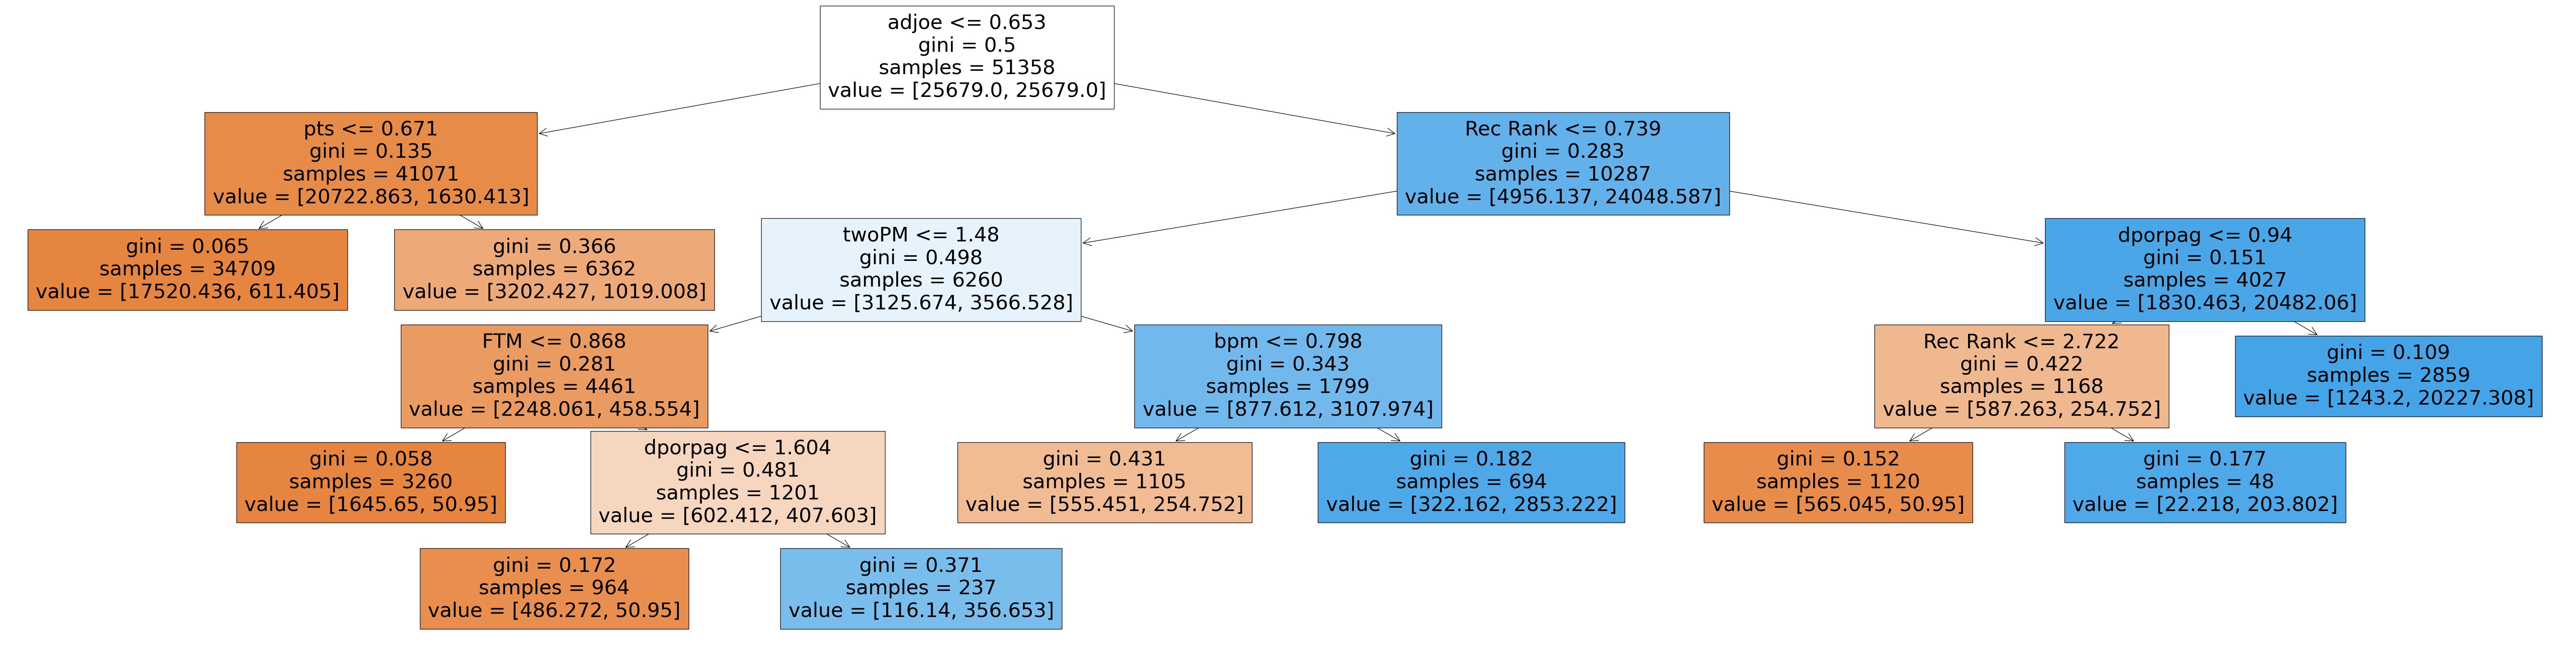

In [51]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize =(80,20))

plot_tree(dtree_gs2cv.best_estimator_, feature_names=data.df_09.columns, max_depth=None, filled=True)

### 3.3. Random forest

import random forest model from framework:

In [90]:
randforest = fw.random_forest()

#### 3.3.1. Stratified 5-fold cross validation without hyperparameter tuning

In [91]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,randforest_5scv = fw.skf_cross_val(
    X=X_scaled, 
    y=data.y, 
    model=randforest, 
    number_of_splits=5, 
    random_state=random_state
    )

eval_scores_randforest_5scv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [92]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[12081,    11],
       [   90,    31]], dtype=int64), array([[12085,     7],
       [   97,    23]], dtype=int64), array([[12082,    10],
       [   84,    36]], dtype=int64), array([[12084,     8],
       [   96,    24]], dtype=int64), array([[12073,    18],
       [   83,    38]], dtype=int64)]

Max precision of draft predictions: 31.4050%
Max accuracy: 43.3735%
Max recall: 99.2303%
Max F1-score: 71.4930%
Max balanced accuracy: 65.6280%


plot the evaluation scores:

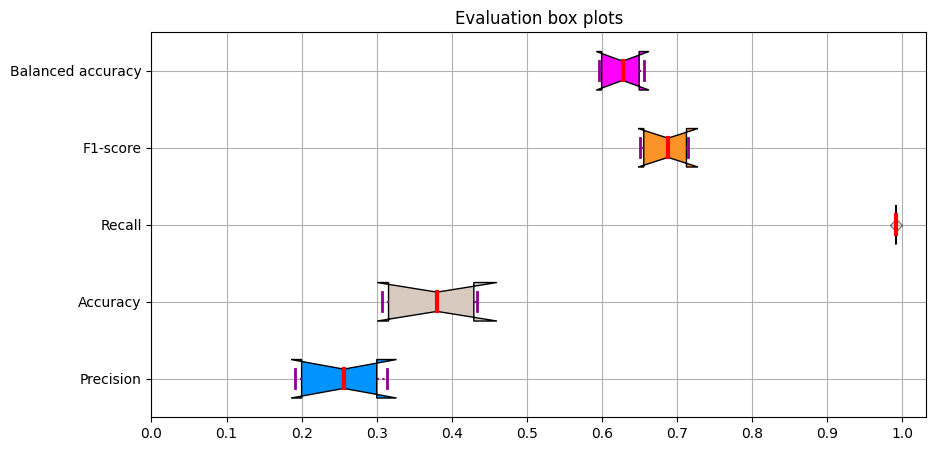

In [93]:
fw.boxplot_eval_scores(eval_data=eval_scores_randforest_5scv)

plot confusion matrices:

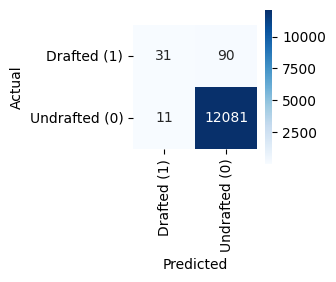

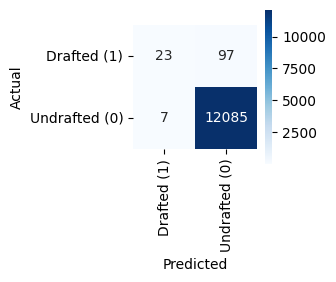

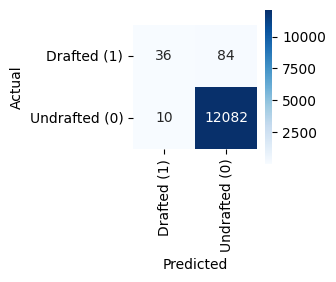

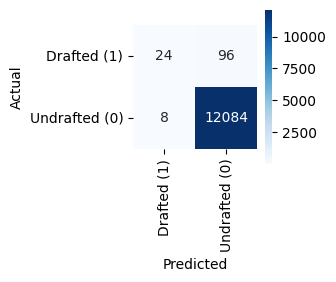

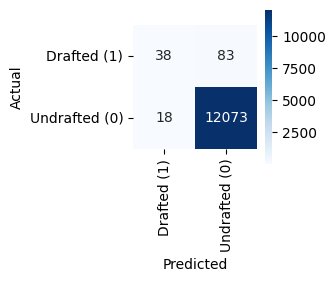

In [94]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

#### 3.3.2. Hyperparameter tuning - GridSearch CV

define parameter grid for the random forest model:

In [95]:
n_estimators = [10,50,100]
max_features = ['auto', 'sqrt']
max_depth = [None,2,5]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 5]
bootstrap = [True, False]

param_grid_randforest = dict(
    n_estimators = n_estimators
    ,max_features = max_features
    ,max_depth = max_depth
    ,min_samples_split = min_samples_split
    ,min_samples_leaf = min_samples_leaf
    ,bootstrap = bootstrap
)

print(param_grid_randforest)

{'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 2, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 5], 'bootstrap': [True, False]}


run gridsearch stratified two-fold cross validation to find best parameters:

In [96]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,randforest_gs2cv = fw.gridsearch_cv(
    X_train=X_train,y_train=y_train,
    X_test=X_test,y_test=y_test,
    number_of_splits=2,param_grid=param_grid_randforest,
    model=randforest.model,random_state=random_state
    )

Fitting 2 folds for each of 324 candidates, totalling 648 fits


store evaluation scores for visualization:

In [97]:
eval_scores_randforest_gs2cv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [98]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[9601,    4],
       [  81,   17]], dtype=int64)]

Max precision of draft predictions: 17.3469%
Max accuracy: 99.1240%
Max recall: 99.1240%
Max F1-score: 64.0654%
Max balanced accuracy: 58.6526%


plot the evaluation of the model:

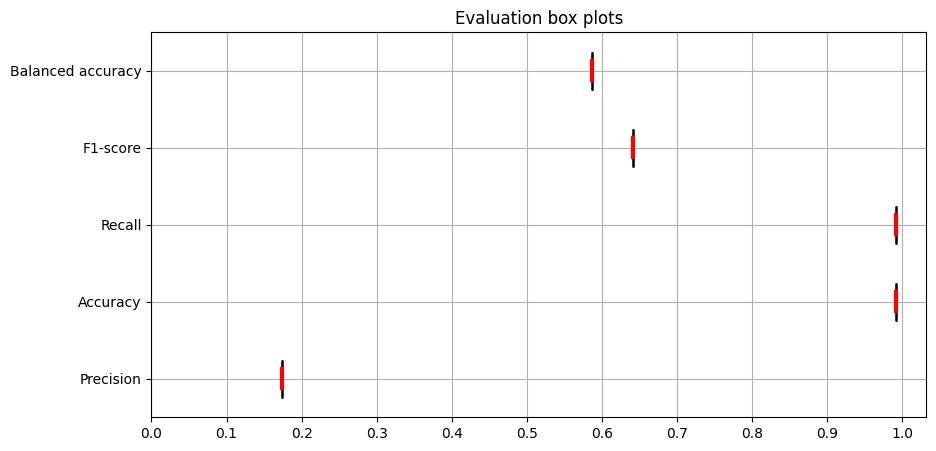

In [99]:
fw.boxplot_eval_scores(eval_data=eval_scores_randforest_gs2cv)

plot confusion matrices:

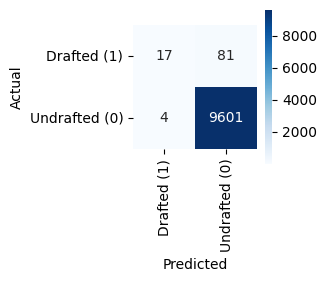

In [100]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

### 3.4. XGBoost

import xgboost model from framework:

In [101]:
xgb = fw.xgboost(missing=0)

#### 3.4.1. Stratified 5-fold cross validation without hyperparameter tuning

In [102]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,xgb_5scv = fw.skf_cross_val(
    X=X_scaled, 
    y=y_true, 
    model=xgb, 
    number_of_splits=5, 
    random_state=random_state
    )

eval_scores_xgb_5scv = [precision,accuracy,recall,f1_score,bal_acc]

[15:23:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[15:25:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



print evaluation scores:

In [103]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[12072,    20],
       [   82,    39]], dtype=int64), array([[12070,    22],
       [   91,    29]], dtype=int64), array([[12077,    15],
       [   78,    42]], dtype=int64), array([[12077,    15],
       [   86,    34]], dtype=int64), array([[12060,    31],
       [   74,    47]], dtype=int64)]

Max precision of draft predictions: 38.8430%
Max accuracy: 47.4576%
Max recall: 99.2385%
Max F1-score: 73.5370%
Max balanced accuracy: 69.2933%


plot the evaluation scores:

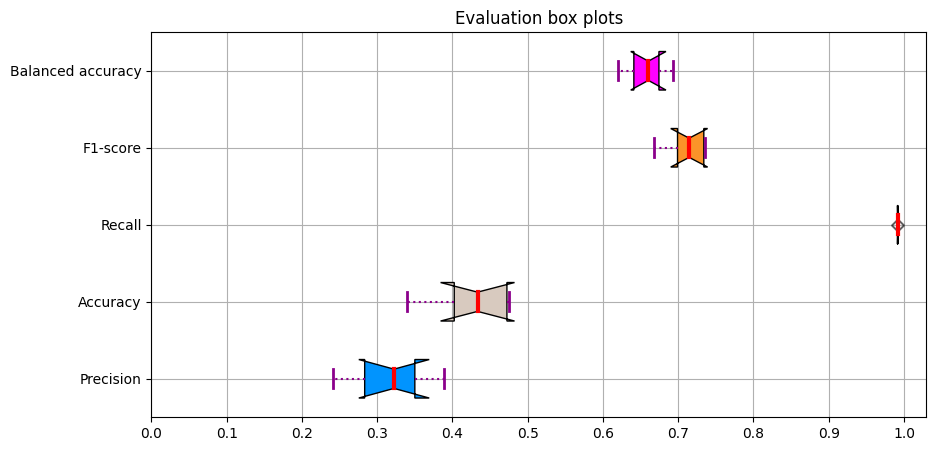

In [104]:
fw.boxplot_eval_scores(eval_data=eval_scores_xgb_5scv)

plot confusion matrices:

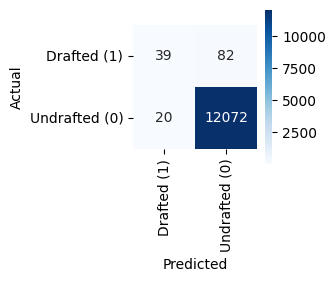

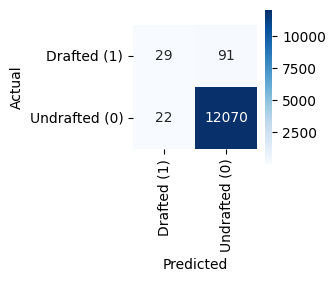

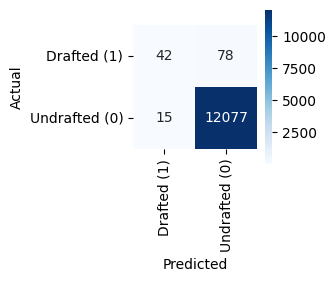

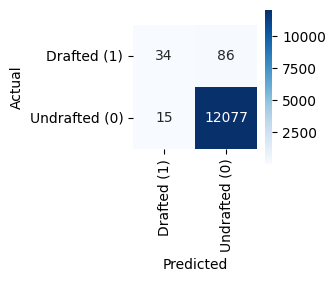

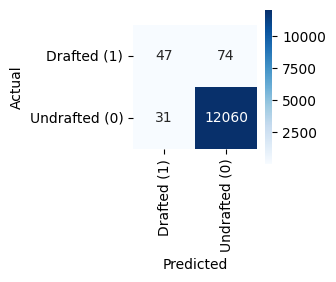

In [105]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

#### 3.4.2. Hyperparameter tuning - GridSearch CV

define parameter grid for the xgboost model using the best decision tree hyperparameters based on the results of the grid search cross validation. Let's see the the best parameters for the decision tree model:

In [111]:
dtree_gs2cv.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 777,
 'splitter': 'best'}

In [115]:
learning_rate = [0.1, 0.01]
n_estimators = [10,50,100]
# max_depth = [None]
# min_child_weight = [1, 5, 10]
gamma = [0, 0.1, 0.5]
# subsample = [0.8, 0.9, 1.0]
# colsample_bytree = [0.8, 0.9, 1.0]
reg_alpha = [0, 0.1, 0.5]
# reg_lambda = [0, 0.1, 0.5]
scale_pos_weight = [1, 2, 5]

param_grid_xgb = dict(
    learning_rate = learning_rate
    ,n_estimators = n_estimators
    ,max_depth = max_depth
#    ,min_child_weight = min_child_weight
    ,gamma = gamma
#    ,subsample = subsample
#    ,colsample_bytree = colsample_bytree
    ,reg_alpha = reg_alpha
#    ,reg_lambda = reg_lambda
    ,scale_pos_weight = scale_pos_weight
)

print(param_grid_xgb)

{'learning_rate': [0.1, 0.01], 'n_estimators': [10, 50, 100], 'max_depth': [None], 'gamma': [0, 0.1, 0.5], 'reg_alpha': [0, 0.1, 0.5], 'scale_pos_weight': [1, 2, 5]}


run gridsearch stratified two-fold cross validation to find best parameters:

In [116]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,xgb_gs2cv = fw.gridsearch_cv(
    X_train=X_train,y_train=y_train,
    X_test=X_test,y_test=y_test,
    number_of_splits=2,param_grid=param_grid_xgb,
    model=xgb.model,random_state=random_state
    )

Fitting 2 folds for each of 162 candidates, totalling 324 fits
[13:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



store evaluation scores for visualization:

In [117]:
eval_scores_xgb_gs2cv = [precision,accuracy,recall,f1_score,bal_acc]

print evaluation scores:

In [118]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[9556,   49],
       [  54,   44]], dtype=int64)]

Max precision of draft predictions: 44.8980%
Max accuracy: 98.9385%
Max recall: 98.9385%
Max F1-score: 72.7686%
Max balanced accuracy: 72.1939%


plot the evaluation of the model:

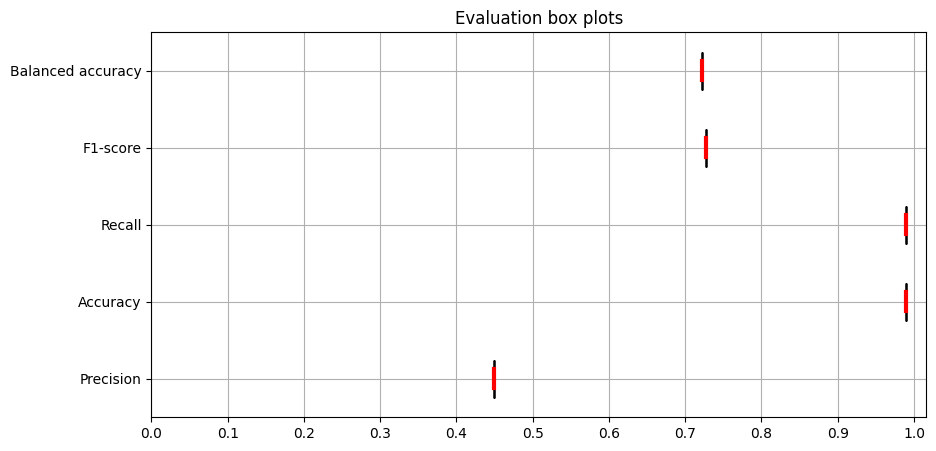

In [119]:
fw.boxplot_eval_scores(eval_data=eval_scores_xgb_gs2cv)

plot confusion matrices:

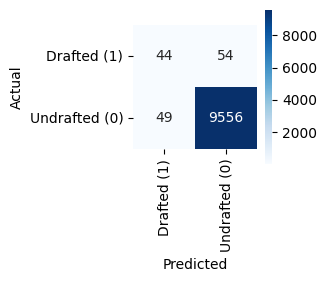

In [120]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

## 4. Improve estimators' performance

The previous models used all features of the data set for the training and prediction of the target variable. Since the data has quite a lot columns and most of them might carry the same information, applying some feature selection techniques might improve the performance of the classificators.

On the other hand, some of the algorithms worked pretty well on the data, but choosing only the most accurate for prediction might lead to worse results than somehow combining all the better learners.

### 4.1. Feature selection: Principal Component Analysis

apply PCA on the data and select top components based on the explained variance ratio:

In [122]:
from sklearn.decomposition import PCA

k = 10

pca = PCA(n_components=k)
X_scaled_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained variance ratio of PC{i+1}: {ratio:.4f}")

Explained variance ratio of PC1: 0.2757
Explained variance ratio of PC2: 0.1281
Explained variance ratio of PC3: 0.1220
Explained variance ratio of PC4: 0.1127
Explained variance ratio of PC5: 0.0833
Explained variance ratio of PC6: 0.0520
Explained variance ratio of PC7: 0.0412
Explained variance ratio of PC8: 0.0360
Explained variance ratio of PC9: 0.0265
Explained variance ratio of PC10: 0.0183


use top components for model training and evaluation:

In [123]:
top_k = 5
X_scaled_pca = X_scaled_pca[:, :top_k]
X_scaled_pca

array([[-0.4727546 , -0.09092409,  0.88836577, -0.09778062,  0.51046173],
       [-0.07273533, -0.12869164,  0.86275417, -0.10106926,  0.73514092],
       [ 0.30505685, -0.2501583 ,  0.14614271,  1.08696503,  0.56990927],
       ...,
       [-1.4987113 , -0.21103054, -0.42921911, -0.03846131, -0.11290576],
       [-1.49835366, -0.21106942, -0.42924218, -0.03846901, -0.11269446],
       [-1.2191209 , -0.2851926 , -0.47656146, -0.12050912,  0.11130188]])

perform 10-fold stratified cross validation on the XGBoost model using principal components: 

In [124]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,xgb_10scv_pca = fw.skf_cross_val(
    X=X_scaled_pca, 
    y=y_true, 
    model=xgb, 
    number_of_splits=10, 
    random_state=random_state
    )

eval_scores_xgb_10scv_pca = [precision,accuracy,recall,f1_score,bal_acc]

[13:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:35:25] WARNING: 

print evaluation scores:

In [125]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[6031,   15],
       [  54,    7]], dtype=int64), array([[6040,    6],
       [  51,    9]], dtype=int64), array([[6037,    9],
       [  45,   15]], dtype=int64), array([[6034,   12],
       [  49,   11]], dtype=int64), array([[6036,   10],
       [  42,   18]], dtype=int64), array([[6039,    7],
       [  43,   17]], dtype=int64), array([[6037,    9],
       [  45,   15]], dtype=int64), array([[6034,   12],
       [  47,   13]], dtype=int64), array([[6030,   16],
       [  47,   13]], dtype=int64), array([[6028,   17],
       [  50,   11]], dtype=int64)]

Max precision of draft predictions: 30.0000%
Max accuracy: 40.9091%
Max recall: 99.1811%
Max F1-score: 70.2401%
Max balanced accuracy: 64.9173%


plot the evaluation scores:

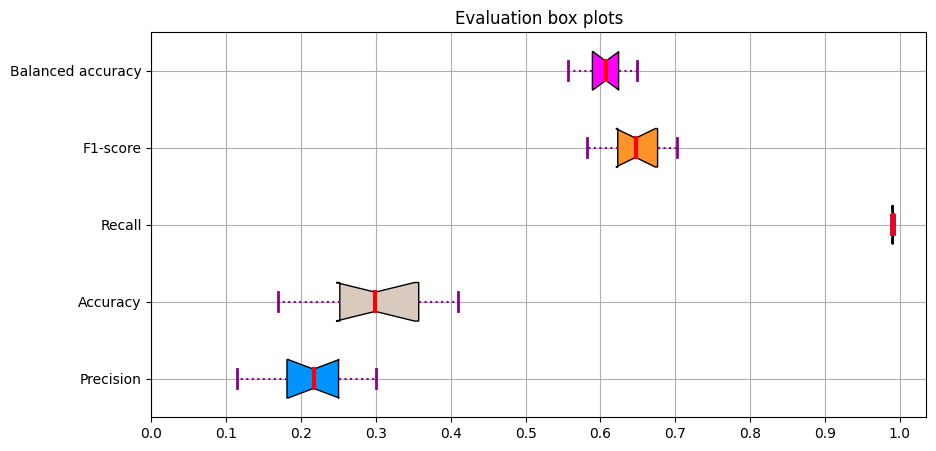

In [126]:
fw.boxplot_eval_scores(eval_data=eval_scores_xgb_10scv_pca)

plot confusion matrices:

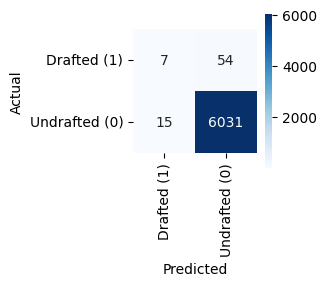

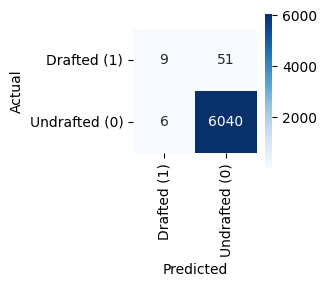

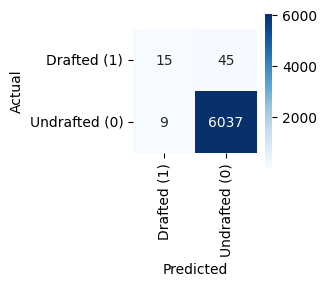

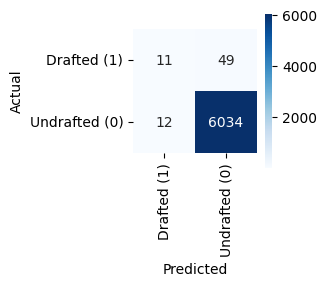

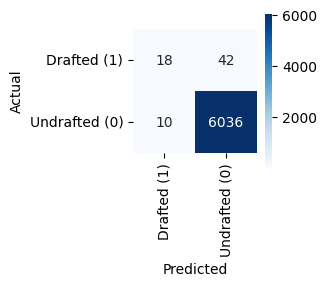

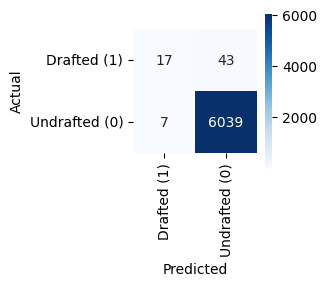

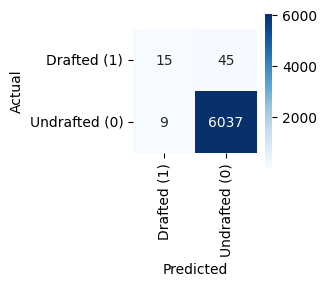

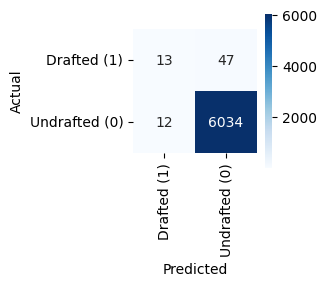

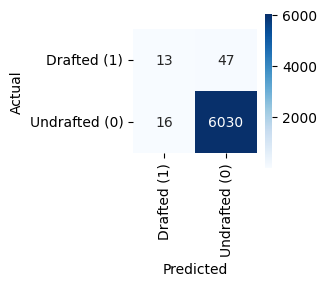

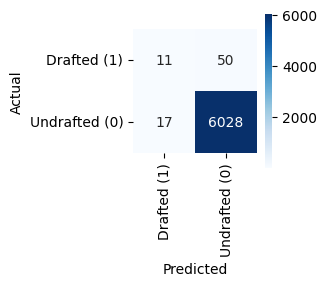

In [127]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

### 4.2. Ensemble classifier: Majority voting

Compare results of classifiers and choose top ones for majority voting:

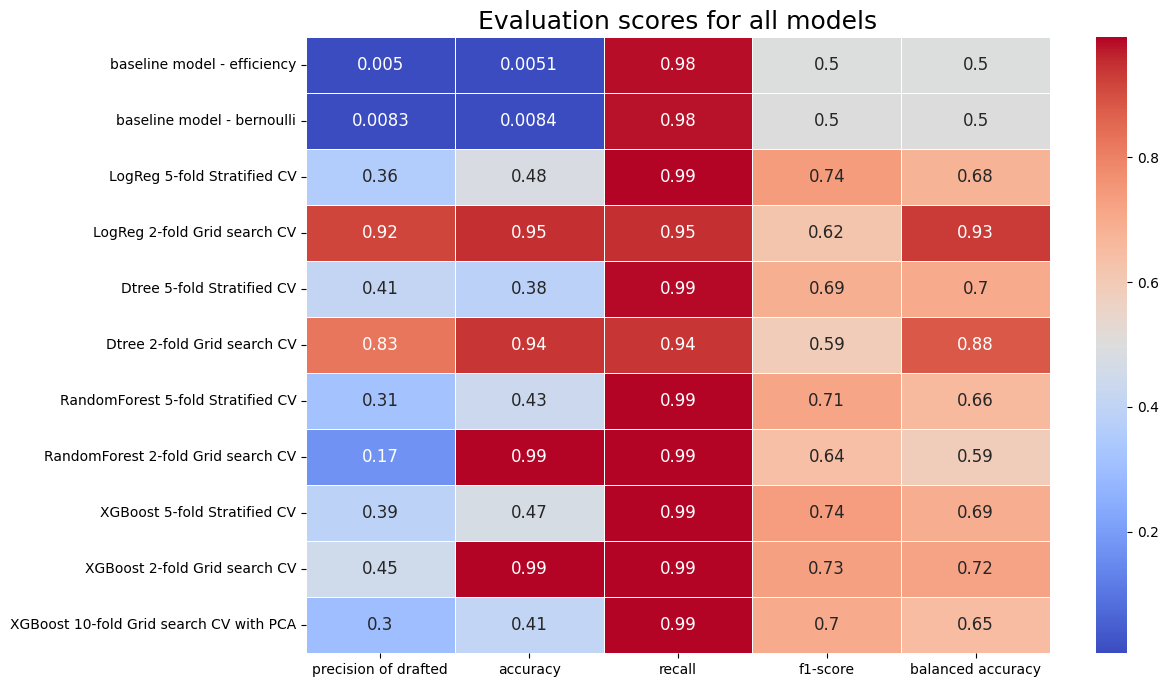

In [198]:
import seaborn as sns

eval_scores = pd.DataFrame(
    data=[
          eval_scores_eff,
          eval_scores_random,
          [max(x) for x in eval_scores_logreg_5scv],
          [x[0] for x in eval_scores_logreg_gs2cv],
          [max(x) for x in eval_scores_dtree_5scv],
          [x[0] for x in eval_scores_dtree_gs2cv],
          [max(x) for x in eval_scores_randforest_5scv],
          [x[0] for x in eval_scores_randforest_gs2cv],
          [max(x) for x in eval_scores_xgb_5scv],
          [x[0] for x in eval_scores_xgb_gs2cv],
          [max(x) for x in eval_scores_xgb_10scv_pca]
          ]
          
)

models = pd.Series(['baseline model - efficiency','baseline model - bernoulli',
           'LogReg 5-fold Stratified CV','LogReg 2-fold Grid search CV',
           'Dtree 5-fold Stratified CV','Dtree 2-fold Grid search CV',
           'RandomForest 5-fold Stratified CV','RandomForest 2-fold Grid search CV',
           'XGBoost 5-fold Stratified CV','XGBoost 2-fold Grid search CV','XGBoost 10-fold Grid search CV with PCA'])

eval_scores = pd.concat([models,eval_scores],axis=1)
eval_scores.columns = ['model','precision of drafted', 'accuracy', 'recall', 'f1-score', 'balanced accuracy']

plt.figure(figsize=(12, 8))
sns.heatmap(eval_scores.iloc[:,1:], annot=True, cmap='coolwarm', annot_kws={'fontsize': 12}, 
            linecolor='white',
            linewidth=.5,
            yticklabels=eval_scores.iloc[:,0],
            xticklabels=eval_scores.columns[1:]
            )
plt.title('Evaluation scores for all models',fontsize=18)

plt.show()

create majority voting classifier using the top performing models:

In [194]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
                ('logreg_gs2cv',logreg_gs2cv.best_estimator_)
                ,('dtree_gs2cv',dtree_gs2cv.best_estimator_)
                ,('xgb_gs2cv', xgb_gs2cv.best_estimator_)
            ], 
    voting='hard'
    )

voting_clf

VotingClassifier(estimators=[('logreg_gs2cv',
                              LogisticRegression(C=0.013257113655901081,
                                                 class_weight='balanced',
                                                 penalty='l1', random_state=777,
                                                 solver='liblinear')),
                             ('dtree_gs2cv',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_features='auto',
                                                     max_leaf_nodes=10,
                                                     random_state=777)),
                             ('xgb_gs2cv',
                              XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None...
                                            feature_types=None, gamma=0.5,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=0, max_depth=None,
                                            max_leaves=None, min_child_weight=1,
                                            missing=0,
                                            monotone_constraints=None,
                                            n_estimators=50, n_jobs=None,
                                            nthread=-1, num_parallel_tree=None,
                                            predictor=None, ...))])

In [204]:
print(voting_clf)

VotingClassifier(estimators=[('logreg_gs2cv',
                              LogisticRegression(C=0.013257113655901081,
                                                 class_weight='balanced',
                                                 penalty='l1', random_state=777,
                                                 solver='liblinear')),
                             ('dtree_gs2cv',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_features='auto',
                                                     max_leaf_nodes=10,
                                                     random_state=777)),
                             ('xgb_gs2cv',
                              XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None...
                                            feature_types=None, gamma=0.5,
                                            gpu_id=None, gr

run test round on the data to see the evaluation scores of the majority voting classifier:

In [197]:
conf_matrix,precision,accuracy,recall,f1_score,bal_acc,voting_clf_10scv = fw.skf_cross_val(
    X=X_scaled, 
    y=y_true, 
    model=voting_clf, 
    number_of_splits=10, 
    random_state=random_state
    )

eval_scores_voting_clf_10scv = [precision,accuracy,recall,f1_score,bal_acc]

[14:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[14:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[14:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[14:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[14:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[14:55:35] WARNING: 

print evaluation scores:

In [199]:
print('Confusion matrix: ',
      conf_matrix,
      '\n'
      'Max precision of draft predictions: {0:.4%}'.format(max(precision)),
      'Max accuracy: {0:.4%}'.format(max(accuracy)),
      'Max recall: {0:.4%}'.format(max(recall)),
      'Max F1-score: {0:.4%}'.format(max(f1_score)),
      'Max balanced accuracy: {0:.4%}'.format(max(bal_acc)),
      sep='\n')

Confusion matrix: 
[array([[5689,  357],
       [   6,   55]], dtype=int64), array([[5733,  313],
       [   7,   53]], dtype=int64), array([[5696,  350],
       [   6,   54]], dtype=int64), array([[5698,  348],
       [   6,   54]], dtype=int64), array([[5688,  358],
       [   3,   57]], dtype=int64), array([[5709,  337],
       [   1,   59]], dtype=int64), array([[5636,  410],
       [   4,   56]], dtype=int64), array([[5672,  374],
       [   3,   57]], dtype=int64), array([[5709,  337],
       [  10,   50]], dtype=int64), array([[5669,  376],
       [   1,   60]], dtype=int64)]

Max precision of draft predictions: 98.3607%
Max accuracy: 25.8772%
Max recall: 94.7593%
Max F1-score: 61.5010%
Max balanced accuracy: 96.3797%


plot the evaluation scores:

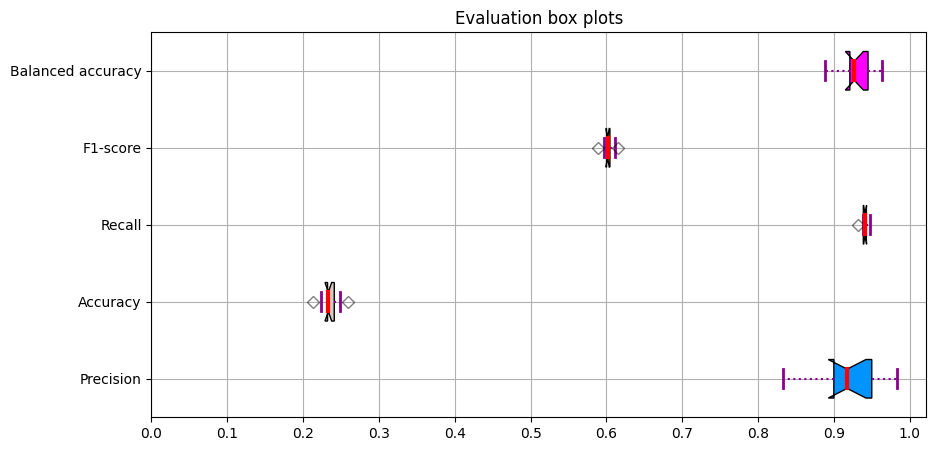

In [201]:
fw.boxplot_eval_scores(eval_data=eval_scores_voting_clf_10scv)

plot confusion matrices:

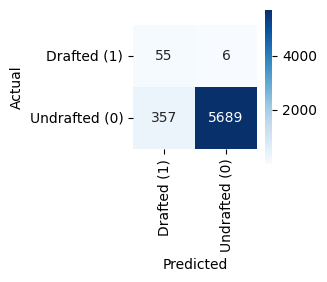

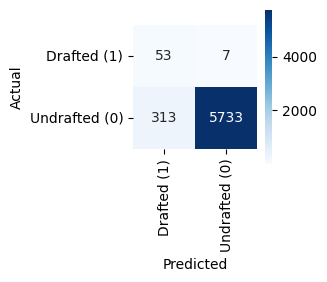

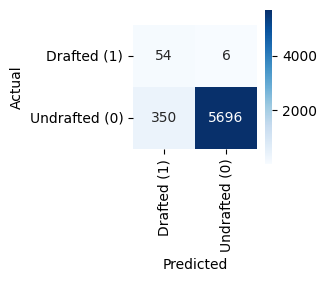

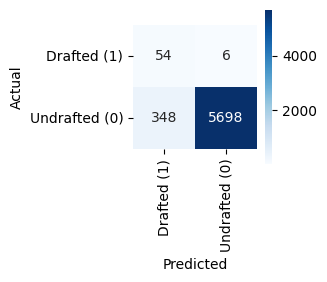

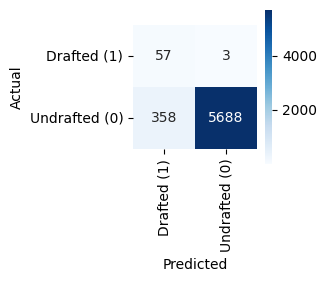

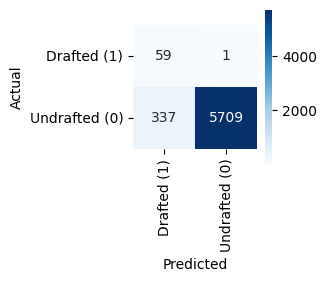

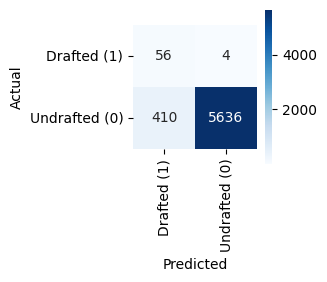

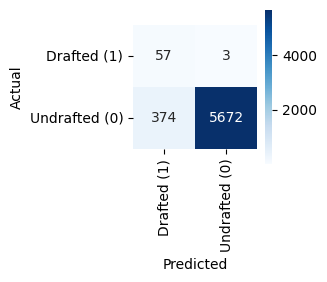

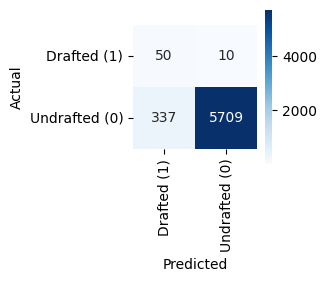

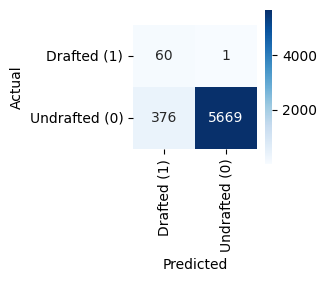

In [202]:
for i in range(len(conf_matrix)):
    fw.cm_heatmap(cm=conf_matrix[i],fig_height=2,fig_width=2)

## 5. Predict actual draft results